In [45]:
%load_ext autoreload
%autoreload 2

# Импорт

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
from skimage.draw import circle
from skimage import transform, filters, exposure, feature
from sklearn.model_selection import train_test_split
import io
from skimage.color import rgb2gray

# Константы

In [11]:
PATH = "D:\\Medicine2020\\Kiestra\\NEW_preprocessed-kla-images"
DESCR = "D:\\Medicine2020\\Kiestra\\NEW_preprocessed-kla-images\ScansDescriptionWithPathCS.csv"
COLUMNS = ["Номер", "Kiestra_ID", "Kiestra_BARCODE", "Kiestra_SCAN_NR", "Kiestra_CS_ID", "Kiestra_CS_DESCRIPTION", "SCAN_PATH", "Результат"]
GROUPS = ["Unknown", "NoGrowth"]

Число участников-пациентов и процент тестовой выборки среди них. Пустой профиль означает все профили

In [12]:
PROFILE = []#["Blood agar Colonies"]
CAP = 400 #100
TRAIN = 0.8 # Если дробное то процент от CAP

In [13]:
r = np.array([[[[1]]],[[[9]]]])
np.repeat(r,2,axis = 1)

array([[[[1]],

        [[1]]],


       [[[9]],

        [[9]]]])

In [14]:
y = [0]*2 + [3]*4
y 


[0, 0, 3, 3, 3, 3]

# Полезные функции

Добавляем в данные булев столбец-результат

In [15]:
def add_result(table, name="RESULT"):
    table = table.copy()
    table[name] = [False if "NoGrowth" in x else True for x in table["SCAN_PATH"]]
    return table

Способ выборки тестовой и тренировочной

In [16]:
def select(index, cap, train):
    if type(train) == int:
        l = train
    else:
        l = int(cap * train)
    return index[:l], index[l:cap]

Подсчет ошибок

In [17]:
def count(patients, model, error_condition=lambda x: x > 0):
    errors = 0
    files = []
    for index in tqdm(patients):
        filenames, vectors = build_vectors([index], silent=True)
        if len(vectors) == 0:
            patients = patients.delete(list(patients).index(index))
            continue
        pred = model.predict(vectors)
        pred = np.rint(pred)
        if error_condition(np.count_nonzero(pred)):
            errors += 1
            files += [filenames[i] for i in range(len(filenames)) if error_condition(pred[i])]
    return patients, errors, files

Подсчет ошибок в общем

In [18]:
def eval(patients_0, patients_1, model):
    _, vectors_0 = build_vectors(patients_0, silent=True)
    _, vectors_1 = build_vectors(patients_1, silent=True)
    X = np.concatenate((vectors_0, vectors_1))
    Y = np.concatenate((np.zeros(len(vectors_0)), np.ones(len(vectors_1))))
    result = np.rint(model.predict(X).flatten())
    errors = np.count_nonzero(result - Y)
    return errors, result

Отображаем картинки

In [19]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images * 2)
    plt.show()

# Считываем описание

In [20]:
description = pd.read_csv(DESCR, ",", decimal=".",
                          index_col=0, dayfirst=True,
                          encoding='utf-8')
description = description[COLUMNS]
description = add_result(description)
if len(PROFILE) > 0:
    description = description[description["Kiestra_CS_DESCRIPTION"].isin(PROFILE)]
description.head()

C:\ProgramData\Anaconda3\envs\Lazuhin\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (31,32,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Номер,Kiestra_ID,Kiestra_BARCODE,Kiestra_SCAN_NR,Kiestra_CS_ID,Kiestra_CS_DESCRIPTION,SCAN_PATH,Результат,RESULT
0,9 991 750 612,4838661,C00002955441,1,2213,Default,Unknown\9991750612\C00002955441\Default\C00002...,11.0,True
1,9 991 750 612,4838661,C00002955441,1,2251,Blood agar General,Unknown\9991750612\C00002955441\BloodAgarGener...,11.0,True
2,9 991 750 612,4838661,C00002955441,1,2252,Blood agar Colonies,Unknown\9991750612\C00002955441\BloodAgarColon...,11.0,True
3,9 991 750 612,4839291,C00002955441,2,2214,Default,Unknown\9991750612\C00002955441\Default\C00002...,11.0,True
4,9 991 750 612,4839291,C00002955441,2,2253,Blood agar General,Unknown\9991750612\C00002955441\BloodAgarGener...,11.0,True


# Делим на Train и Test

Все пациенты

In [21]:
patients = description[["Номер", "RESULT"]].groupby("Номер").mean()
patients

,RESULT
Номер,
1 106 763 898,True
1 107 334 057,True
1 107 334 142,False
1 107 334 193,True
1 107 439 324,True
...,...
9 999 234 331,True
9 999 234 354,False
9 999 234 364,True


In [22]:
ALL_NOGROWTH = len(patients[patients['RESULT']==False])
ALL_UNKNOWN = len(patients[patients['RESULT']==True])

Делим на выборки, select определена выше

In [23]:
unknown_train, unknown_test = select(patients[patients["RESULT"]].index, ALL_UNKNOWN, train=TRAIN)
no_growth_train, no_growth_test = select(patients[~patients["RESULT"]].index, ALL_NOGROWTH, train=TRAIN)
print(len(unknown_train), len(unknown_test), TRAIN, ALL_UNKNOWN)
print(len(no_growth_train), len(no_growth_test), TRAIN, ALL_NOGROWTH)

2569 643 0.8 3212
222 56 0.8 278


# Функция считывания картинок и группировки

Считываем по каждому участнику списка

In [24]:
EXPERIMENT = ["Номер", "SCAN_PATH", "Kiestra_SCAN_NR", "Kiestra_CS_DESCRIPTION", "Kiestra_BARCODE"]
PATIENTS = description[EXPERIMENT].groupby("Номер")
def read(patients, select=lambda x: x, silent=False):
    IMAGES = []
    filenames = []
    groups = []
    wrap = lambda x: x if silent else tqdm(x)
    # Пациенты
    for index in wrap(patients):
        try:
            group = PATIENTS.get_group(index)
            # Чашки
            one_person = []
            one_person_images = []
            for barcode, btable in group.groupby("Kiestra_BARCODE"):
                
                # Профили
                for profile, ptable in btable.groupby("Kiestra_CS_DESCRIPTION"):
                    # Пути
                    one_person.append(ptable)
                    for path in select(sorted(ptable["SCAN_PATH"])):
                        #print(index, barcode, profile, path.split("_")[1])
                        path = os.path.join(PATH, path)
                        one_person_images.append(np.asarray(Image.open(path)))
                        filenames.append(path)
            groups.append(one_person)
            IMAGES.append(one_person_images)
        except:
            continue
    IMAGES = np.asarray(IMAGES)
    groups = np.asarray(groups)
    return filenames, IMAGES, groups

Демо

# Cписок пар изображений для каждого эксперимента

In [25]:
def pictures_num_to_differ(table):
    numbers = []
    for person in table:
        one_person_numbers = []
        count = -1
        for groups in person:
            count+=1
            for i in range(len(groups)-1):
                one_person_numbers.append((count,count+1))
                count+=1
        numbers.append(np.array(one_person_numbers))
    return numbers

# Список вычетов одного изображения из другого (работает пока медленно)

In [26]:
def image_subtraction(images, numbers):
    subtractions = []
    all_subs = []
    for p_img, p_num in tqdm(zip(images, numbers)):
        person_subtractions = []
        for i in p_num:
            person_subtractions.append(abs(p_img[i[1]].astype('int16')-p_img[i[0]].astype('int16')))
        subtractions.append(person_subtractions)
        all_subs.extend(person_subtractions)
    return subtractions, all_subs

In [27]:
_, images_ng, table_ng = read(no_growth_train[:150], silent=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.73s/it]
C:\ProgramData\Anaconda3\envs\Lazuhin\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


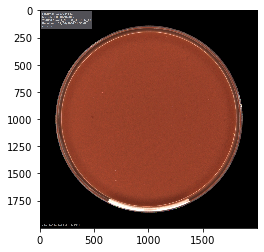

In [29]:
plt.imshow(images_ng[0][0])

In [117]:
_, images_un, table_un = read(unknown_train[:150], silent=False)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [07:29<00:00,  2.99s/it]


In [118]:
numbers_ng = pictures_num_to_differ(table_ng)

In [119]:
numbers_un = pictures_num_to_differ(table_un)

In [120]:
per_subs_ng, all_subs_ng = image_subtraction(images_ng, numbers_ng)

140it [03:33,  1.53s/it]


In [121]:
per_subs_un, all_subs_un = image_subtraction(images_un, numbers_un)

132it [03:50,  1.74s/it]


In [22]:
len(all_subs_un)

1383

In [23]:
len(all_subs_ng)

1446

In [122]:
y = [0]*len(all_subs_un)
y.extend([1]*len(all_subs_ng))
print(len(y))

5269


In [123]:
X = []
for i in tqdm(all_subs_un):
    X.append(list(i))  

100%|████████████████████████████████████████████████████████████████████████████| 2660/2660 [00:01<00:00, 2213.24it/s]


In [124]:
for i in tqdm(all_subs_ng):
    X.append(list(i))

100%|████████████████████████████████████████████████████████████████████████████| 2609/2609 [00:01<00:00, 2108.45it/s]


In [ ]:
X_data = []
for i in tqdm(range(len(X))):
    X_data.append(PREPROCESS(X[i]))

In [ ]:
X_data = np.array(X_data)

In [63]:
X_data.shape

(2829, 200, 200, 3)

In [129]:
from sklearn.utils import shuffle

In [130]:
X_data, y = shuffle(X_data,y)

In [38]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers

In [103]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=35,
    horizontal_flip=True,
    rescale=1./255)
datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y, test_size=0.2, random_state=42)

In [104]:
datagen_train.fit(X)

In [107]:
train = datagen_train.flow(np.array(X_train), y_train, batch_size=32)
validation = datagen_val.flow(np.array(X_val), y_val, batch_size=32)

In [56]:
learning_rate_reduction = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='elu', padding = 'same',kernel_initializer='he_uniform', input_shape=(200,200,3)))
model.add(layers.BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
#model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='elu', padding = 'same', kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128, kernel_size=(3,3), activation='elu', padding = 'same', kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(2,2)))
#model.add(layers.Dropout(0.5))
#model.add(layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding = 'same', kernel_initializer='he_uniform'))
#model.add(layers.BatchNormalization())
#model.add(layers.AveragePooling2D(pool_size=(2,2)))
#model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(
        train,
        steps_per_epoch = len(X_train) / 32,
        epochs=30,
        verbose = 1,
        validation_data = validation,
        validation_steps = len(X_val) / 32,
        callbacks = [learning_rate_reduction])

In [ ]:
#model.fit(
#        X, y,
#        batch_size = 32,
#        epochs=30,
#        verbose = 1,
#        validation_split = 0.1,
#        callbacks = [learning_rate_reduction])

# Функция предобработки

Параметры - исходный размер, размер границ и размер до которого ресайзим

In [32]:
D = 2000
RIM = 300
SIZE = 200

Функция предобработки, сглаживание и эквализация гистограммы закоментированы, тут только ресайз и обрезка

In [88]:
CENTER = D/2 - RIM
MASK = np.zeros((D, D, 3))[RIM:-RIM, RIM:-RIM]
MASK[circle(CENTER, CENTER, CENTER)] = 1
def PREPROCESS(image):
    
    # Cutting circle
    image = image[RIM:-RIM, RIM:-RIM]
    image = image * MASK
    
    # Equalizing histogram
    #image /= 255
    #image = exposure.equalize_adapthist(image)
    
    # Filtering
    #image = filters.gaussian(image, sigma=1.0, multichannel=True)
    
    # Resizing
    image = transform.resize(image, (SIZE, SIZE,3))
    
    return image.astype(int)

C:\ProgramData\Anaconda3\envs\Lazuhin\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
img = PREPROCESS(images_ng[0][0])

In [98]:
img3 = PREPROCESS(images_ng[0][8])

In [64]:
img = np.reshape(img, (1,)+img.shape)

In [91]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, rotation_range = 30)

In [92]:
mask = np.zeros((200, 200, 3))

In [93]:
mask[circle(100, 100, 100)] = 1

C:\ProgramData\Anaconda3\envs\Lazuhin\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  """Entry point for launching an IPython kernel.


(200, 200, 3)


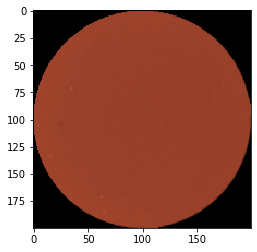

(200, 200, 3)


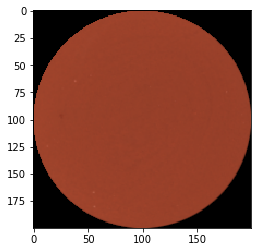

(200, 200, 3)


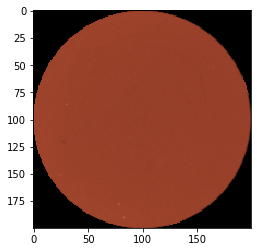

(200, 200, 3)


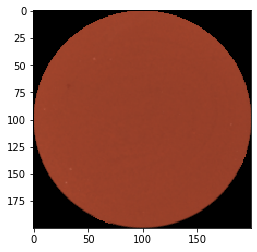

(200, 200, 3)


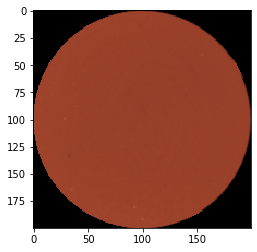

In [94]:
for i in range(5):
    for batch in datagen.flow(img, batch_size=1):
        print(batch[0].shape)
        
        plt.imshow(mask*batch[0])
        plt.show()
        break

Демо

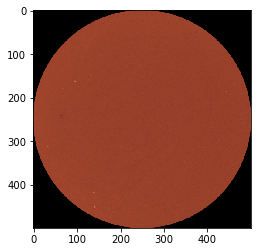

In [26]:
plt.imshow(PREPROCESS(image[0]))

# Функция построения пространства признаков

Как пример используется HOG. Функция должна возвращать признак+визуализацию(чисто для демонстрации)

In [27]:
FEATURE = lambda x: feature.hog(x, orientations=9, pixels_per_cell=(50, 50), 
                    cells_per_block=(3, 3), block_norm='L2-Hys', 
                    visualize=True, transform_sqrt=False, feature_vector=True, multichannel=True)
#FEATURE = lambda x: (np.histogram(x.ravel(), bins = 1024)[0], np.zeros((3, 3, 3)))

Демо

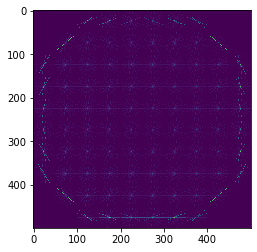

In [28]:
plt.imshow(FEATURE(PREPROCESS(image[0]))[1])

# Функция построения тренировочного набора

In [29]:
def build_vectors(patients, select=lambda x: x, silent=False):
    X = []
    wrap = lambda x: x if silent else tqdm(x)
    filenames, images = read(patients, select=select, silent=silent)
    for image in wrap(images):
        image = PREPROCESS(image)
        vector, demo = FEATURE(image)
        X.append(vector)#vector.flatten())
    X = np.asarray(X) 
    return filenames, X

# Обучение

Размер валидационной подвыборки

In [21]:
VALID = 0.25

Тренировочные вектора. select это лямбда что применяется к последовательности чашек.

In [22]:
_, unknown = build_vectors(unknown_train, select=lambda x: x[-1:])
_, no_growth = build_vectors(no_growth_train)
X = np.concatenate((unknown, no_growth))
Y = np.concatenate((np.ones(len(unknown)), np.zeros(len(no_growth))))
print(X.shape, Y.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 3820/3820 [30:38<00:00,  2.08it/s]


(4961, 5184) (4961,)


In [31]:
_, no_growth = build_vectors(no_growth_train)
print(no_growth.shape)

  1%|▍                                                                                | 9/1464 [00:04<12:09,  2.00it/s]


KeyboardInterrupt: 

Тренировочная-валидационная выборки

In [23]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=VALID, random_state=0)
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)

(3720, 5184) (3720,)
(1241, 5184) (1241,)


Обучаем модель

In [24]:
model = SimpleLGBM(
    
    boosting_type='gbdt',
    n_estimators=100,
    
    objective='binary',
    
    subsample_freq=0,
    subsample=1,            
    colsample_bytree=1,
            
    num_leaves=32,
    learning_rate=0.1,
    max_depth=-1,
            
    reg_alpha=0,
    reg_lambda=0,
                
    min_split_gain=0.0,                                        
    min_child_weight=0.001,
    min_child_samples=20,
    
    #subsample_for_bin=10000
)

model.fit(train_set=(X_train, Y_train), 
             val_set=(X_valid, Y_valid),
             patience=15,
             verbose=2)

Training until validation scores don't improve for 15 rounds
[2]	valid_0's binary_logloss: 0.430227
[4]	valid_0's binary_logloss: 0.369062
[6]	valid_0's binary_logloss: 0.326662
[8]	valid_0's binary_logloss: 0.295774
[10]	valid_0's binary_logloss: 0.269
[12]	valid_0's binary_logloss: 0.251047
[14]	valid_0's binary_logloss: 0.234603
[16]	valid_0's binary_logloss: 0.222391
[18]	valid_0's binary_logloss: 0.212801
[20]	valid_0's binary_logloss: 0.207129
[22]	valid_0's binary_logloss: 0.200648
[24]	valid_0's binary_logloss: 0.19559
[26]	valid_0's binary_logloss: 0.190385
[28]	valid_0's binary_logloss: 0.185749
[30]	valid_0's binary_logloss: 0.181617
[32]	valid_0's binary_logloss: 0.178996
[34]	valid_0's binary_logloss: 0.176696
[36]	valid_0's binary_logloss: 0.175543
[38]	valid_0's binary_logloss: 0.172872
[40]	valid_0's binary_logloss: 0.172335
[42]	valid_0's binary_logloss: 0.172425
[44]	valid_0's binary_logloss: 0.170854
[46]	valid_0's binary_logloss: 0.169656
[48]	valid_0's binary_loglo

# Проверка

NoGrowth - test

In [33]:
no_growth_test, no_growth_test_errors, no_growth_test_files = count(no_growth_test, model, error_condition=lambda x: x > 0)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [12:59<00:00, 15.59s/it]


In [34]:
print(f"Ошибок: {no_growth_test_errors} из {len(no_growth_test)} пациентов без роста")

Ошибок: 11 из 49 пациентов без роста


NoGrowth - train

In [35]:
no_growth_train, no_growth_train_errors, no_growth_train_files = count(no_growth_train, model, error_condition=lambda x: x > 0)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [38:45<00:00, 15.51s/it]


In [36]:
print(f"Ошибок: {no_growth_train_errors} из {len(no_growth_train)} пациентов без роста")

Ошибок: 9 из 140 пациентов без роста


Unknown - test

In [37]:
unknown_test, unknown_test_errors, unknown_test_files = count(unknown_test, model, error_condition=lambda x: x == 0)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [17:25<00:00, 20.91s/it]


In [38]:
print(f"Ошибок: {unknown_test_errors} из {len(unknown_test)} пациентов с ростом")

Ошибок: 0 из 48 пациентов с ростом


Unknown - train

In [39]:
unknown_train, unknown_train_errors, unknown_train_files = count(unknown_train, model, error_condition=lambda x: x == 0)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [39:39<00:00, 15.86s/it]


In [40]:
print(f"Ошибок: {unknown_train_errors} из {len(unknown_train)} пациентов с ростом")

Ошибок: 0 из 134 пациентов с ростом


Общий - test

In [ ]:
both_test_errors, both_test_result = eval(no_growth_test, unknown_test, model)

Общий - train

In [ ]:
both_train_errors, both_train_result = eval(no_growth_train, unknown_train, model)

Таблица

In [51]:
pd.DataFrame(index=["NoGrowth", "Unknown", "Both"],
             columns=["Train", "Test"],
             data=[
                 [1 - no_growth_train_errors/len(no_growth_train), 1 - no_growth_test_errors/len(no_growth_test)],
                  [1 - unknown_train_errors/len(unknown_train), 1 - unknown_test_errors/len(unknown_test)],
                    [1 - both_train_errors/len(both_train_result), 1 - both_test_errors/len(both_test_result)]
                    ])

,Train,Test
NoGrowth,0.935714,0.775510
Unknown,1.000000,1.000000
Both,0.843523,0.803908


# Смотрим ошибки

No growth

In [52]:
print(' (test)\n'.join(no_growth_test_files))
print(' (train)\n'.join(no_growth_train_files))

D:\Medicine2020\Kiestra\NEW_preprocessed-kla-images\NoGrowth\9991739734\C00002948555\BloodAgarColonies\C00002948555_2_2545.jpg (test)
D:\Medicine2020\Kiestra\NEW_preprocessed-kla-images\NoGrowth\9991739734\C00002948555\BloodAgarColonies\C00002948555_3_2646.jpg (test)
D:\Medicine2020\Kiestra\NEW_preprocessed-kla-images\NoGrowth\9991739734\C00002948555\BloodAgarGeneral\C00002948555_3_2648.jpg (test)
D:\Medicine2020\Kiestra\NEW_preprocessed-kla-images\NoGrowth\9991739734\C00002948557\Chromagar\C00002948557_4_2655.jpg (test)
D:\Medicine2020\Kiestra\NEW_preprocessed-kla-images\NoGrowth\9991739734\C00002948557\Default\C00002948557_4_2654.jpg (test)
D:\Medicine2020\Kiestra\NEW_preprocessed-kla-images\NoGrowth\9991739913\C00002986200\CustomProfile\C00002986200_1_2449.jpg (test)
D:\Medicine2020\Kiestra\NEW_preprocessed-kla-images\NoGrowth\9991740114\C00002948990\BloodAgarColonies\C00002948990_3_2650.jpg (test)
D:\Medicine2020\Kiestra\NEW_preprocessed-kla-images\NoGrowth\9991740114\C00002948990\

Unknown

In [53]:
print(' (test)\n'.join(unknown_test_files))
print(' (train)\n'.join(unknown_train_files))

Картинки

In [ ]:
SET = no_growth_test_files[:10]

In [ ]:
show_images([np.asarray(Image.open(path)) for path in SET], cols=len(SET), titles=SET)